In [3]:
import limpy.lines as ll
import limpy.theory as lt
import limpy.utils as lu
import limpy.inputs as inp
import limpy.cosmos as cosmos

import numpy as np

In [4]:
cosmo_params_inputs = {
    "h": inp.h,
    "omega_lambda": inp.omega_lambda,
    "omega_b": inp.omega_b,
    "omega_m": inp.omega_m,
    "tau": inp.tau,
    "ns": inp.ns,
    "sigma_8": inp.sigma_8,
    "halo_model": inp.halo_model,
    "halo_mass_def": inp.halo_mass_def,
    "M_min": inp.M_min,
    "M_max": inp.M_max,
    "delta_c": inp.delta_c,
    "bias_model": inp.bias_model,
    "bias_mass_def": inp.bias_mass_def
}

AttributeError: module 'limpy.inputs' has no attribute 'h'

In [20]:
cosmo_params_inputs

{'h': 0.6776,
 'omega_lambda': 0.6889,
 'omega_b': 0.0489,
 'omega_m': 0.3111,
 'tau': 0.056,
 'ns': 0.9665,
 'sigma_8': 0.81,
 'halo_model': 'sheth99',
 'halo_mass_def': 'fof',
 'M_min': 100000000.0,
 'M_max': 1e+19,
 'delta_c': 1.68,
 'bias_model': 'sheth01',
 'bias_mass_def': 'vir'}

In [21]:
def configure_params_fisher(params_fisher, line_name = "CII158", step_size=50):

    steps = {key: value / step_size for key, value in params_fisher.items()}
    
    return params_fisher, steps

In [22]:
def compute_derivatives_pk3d_analytical(
                      k_values,
                      z,
                      params_fisher, 
                      line_name='CII158',
                      sfr_model="Silva15",
                      model_name ="Alma_scalling"):
    
    
    
    param_numbers=len(params_fisher)
    dcldp=[]
    
    for i in range(param_numbers):
        p=list(params_fisher.keys())[i]
        print("varying :", p)
        params_deriv = params_fisher.copy()	
        params_deriv[p] = params_deriv[p] + steps[p]
        
        updated_params = {
        key: params_deriv[key] if key in params_deriv else cosmo_params_inputs[key]
        for key in cosmo_params_inputs}
        
        cosmo_setup = cosmos.cosmo(h = updated_params['h'],
                                    omega_lambda = updated_params['omega_lambda'],
                                    omega_b = updated_params['omega_b'],
                                    omega_m = updated_params['omega_m'],
                                    tau = updated_params['tau'],
                                    ns = updated_params['ns'],
                                    sigma_8 = updated_params['sigma_8'],
                                    halo_model = updated_params['halo_model'],
                                    halo_mass_def = updated_params['halo_mass_def'],
                                    M_min = updated_params['M_min'],
                                    M_max = updated_params['M_max'],
                                    delta_c = updated_params['delta_c'],
                                    bias_model = updated_params['bias_model'],
                                    bias_mass_def = updated_params['bias_mass_def'])


        
        pk_plus = lt.Pk_line(k_values, z, model_name=model_name, line_name=line_name,
                             sfr_model =sfr_model, params_fisher=params_deriv)
        
        
    
        del params_deriv
        del updated_params
        
        
        
        
        params_deriv = params_fisher.copy()
        params_deriv[p] = params_deriv[p] - steps[p] 
        
        updated_params = {
        key: params_deriv[key] if key in params_deriv else cosmo_params_inputs[key]
        for key in cosmo_params_inputs}
        
        cosmo_setup = cosmos.cosmo(h = updated_params['h'],
                                    omega_lambda = updated_params['omega_lambda'],
                                    omega_b = updated_params['omega_b'],
                                    omega_m = updated_params['omega_m'],
                                    tau = updated_params['tau'],
                                    ns = updated_params['ns'],
                                    sigma_8 = updated_params['sigma_8'],
                                    halo_model = updated_params['halo_model'],
                                    halo_mass_def = updated_params['halo_mass_def'],
                                    M_min = updated_params['M_min'],
                                    M_max = updated_params['M_max'],
                                    delta_c = updated_params['delta_c'],
                                    bias_model = updated_params['bias_model'],
                                    bias_mass_def = updated_params['bias_mass_def'])
        
        
        
        pk_minus = lt.Pk_line(k_values, z, model_name=model_name, line_name=line_name,
                             sfr_model =sfr_model, params_fisher=params_deriv)
        
        
        dcldp_cal=(pk_plus - pk_minus)/ (2. * steps[p])
        dcldp.append(dcldp_cal)
        
        del params_deriv
        
    return dcldp
        

    
    

In [23]:
def fisher_pk3d(k_values,
                      z,
                      params_fisher,
                      derivative_matrix=None,
                      cov_matrix=None,
                      line_name='CII158',
                      sfr_model="Silva15",
                      model_name ="Alma_scalling"):
    
    # This function calculates the fisher matrix for a given covariance matrix. If derivative is precomputed
    # it can can be passed as an input, otherwise, the code will calculate the derivative. 
    
    
    if derivative_matrix is None:
        print("Calculating derivative")
        derivative = compute_derivatives_pk3d_analytical(
                      k_values,
                      z,
                      params_fisher, 
                      line_name= line_name,
                      sfr_model= sfr_model,
                      model_name = model_name)
        
    else:
        derivative = derivative_matrix
        
    
    nparams=len(params_fisher)
    F=np.zeros((nparams, nparams))
    clderiv_i = derivative
    clderiv_j = derivative
    

    for i in range(nparams):
        for j in range(nparams):
            F[i][j]=np.sum(clderiv_i[i]* cov_matrix**-1 * clderiv_j[j]) 
            
    return F

In [24]:
def get_gaussian_error(pk_error, k):
    covariance_matrix = pk_error ** 2
    return covariance_matrix

In [25]:
cosmo_setup = cosmos.cosmo()
kvals = np.logspace(-1, 1, num=20)
z = 4.6
pk = lt.Pk_line(kvals, 3.6, model_name="Alma_scalling")



cosmo_setup = cosmos.cosmo(omega_lambda=0.2)
pk1 = lt.Pk_line(kvals, 3.6, model_name="Alma_scalling")

In [26]:
params_fisher ={
            "omega_m": 0.3,
            "sigma_8": 0.8}

params_fisher_input, steps = configure_params_fisher(params_fisher)


In [33]:
cosmo_setup = cosmos.cosmo(sigma_8 =0.8)
kvals = np.logspace(-1, 1, num=20)
pk = lt.Pk_line(kvals, z, model_name="Alma_scalling")

cosmo_setup = cosmos.cosmo(sigma_8 =0.85)
pk1 = lt.Pk_line(kvals, z, model_name="Alma_scalling", params_fisher=params_fisher_input)
pk_err = pk1* 0.3 

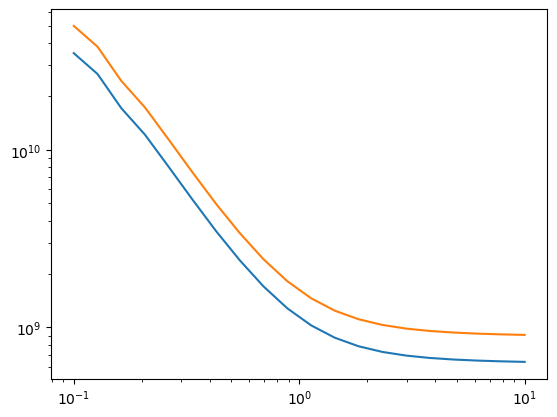

In [34]:
import matplotlib.pyplot as plt
plt.loglog(kvals, pk)
plt.loglog(kvals, pk1)

In [35]:
cov_mat = get_gaussian_error(pk_err, kvals)

In [36]:
Fij = fisher_pk3d(kvals,
                      z,
                      params_fisher_input,
                      derivative_matrix=None,
                      cov_matrix=cov_mat,
                      line_name='CII158',
                      sfr_model="Silva15",
                      model_name ="Alma_scalling")

Calculating derivative
varying : omega_m
varying : sigma_8


In [37]:
cov_params = np.linalg.inv(Fij)

params_fisher_names= list(params_fisher_input.keys())

params_label=params_fisher_names
params_fisher_names_plot=params_fisher_names

mean=[params_fisher[params_fisher_names_plot[i]] for i in range(len(params_fisher_names_plot))]


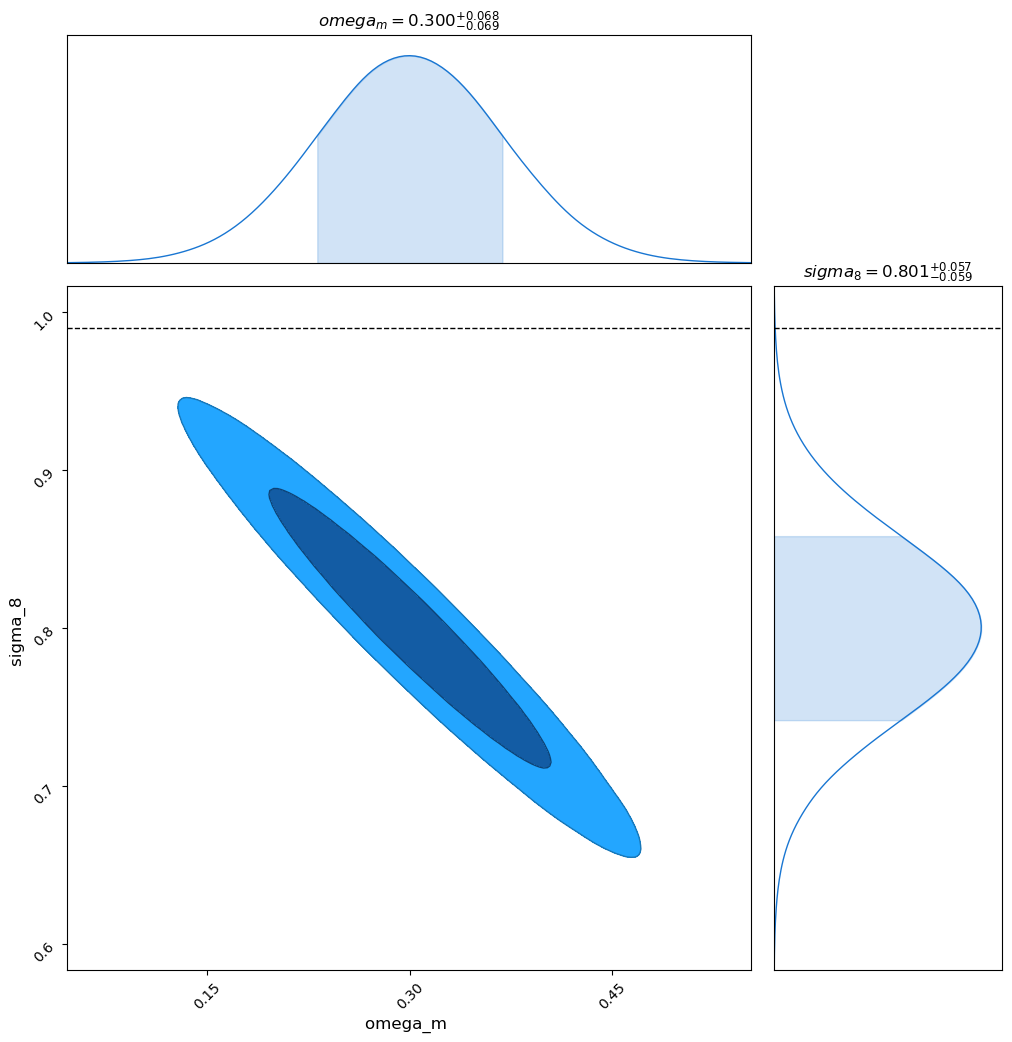

In [38]:
from chainconsumer import ChainConsumer


c = ChainConsumer()


colors=[ '#C59A06', '#046DD0', '#C70039', 'green', 'm', 'orange', 'brown', 'magenta']


c.add_covariance(mean, cov_params, parameters=params_label)


fig = c.plotter.plot(figsize=(8,8), truth=[6.98, 0.99])
fig.set_size_inches(3+ fig.get_size_inches()) 


#plt.savefig("fisher_lim.png")

In [43]:
def pk3d_interloper(k, 
                        line_name='CII158',
                        sfr_model="Silva15",
                        model_name="Alma_scalling",
                        params_fisher=None,
                        nu_obs=410, 
                        dnu_obs=40,
                        zlim=10):
    
    z_int, dz_int, int_line_names = lu.get_lines_same_frequency(int_line_list, 
                                                               nu_obs=nu_obs,
                                                               dnu_obs=dnu_obs, 
                                                               zlim=zlim)
    pk_total = []
    
    for i, z in enumerate(z_int):
        print("Calculating powerspectrum for {:s} lines at z={:.2f}".format(int_line_names[i], z))
        pk_int = lt.Pk_line(k, z, model_name=model_name, line_name=line_name,
                            sfr_model=sfr_model, params_fisher=params_fisher)
        pk_total.append(pk_int)
        
    pk_final = np.sum(pk_total, axis=0)
        
    return pk_final

    
    
    
    

In [42]:
pkint = pk3d_interloper(kvals, 
                      line_name='CO32',
                      sfr_model="Silva15",
                      model_name ="Alma_scalling",
                      params_fisher=None,
                      nu_obs=410, 
                      dnu_obs=40,
                      zlim=10)

Calculating powerspectrum for CII158 lines at z=3.63
Calculating powerspectrum for CO43 lines at z=0.12
Calculating powerspectrum for CO54 lines at z=0.40
Calculating powerspectrum for CO65 lines at z=0.68
Calculating powerspectrum for CO76 lines at z=0.96
Calculating powerspectrum for CO87 lines at z=1.24
Calculating powerspectrum for CO98 lines at z=1.52
Calculating powerspectrum for CO109 lines at z=1.80
Calculating powerspectrum for CO1110 lines at z=2.08
Calculating powerspectrum for CO1211 lines at z=2.36
Calculating powerspectrum for CO1312 lines at z=2.64
Calculating powerspectrum for OIII88 lines at z=7.31


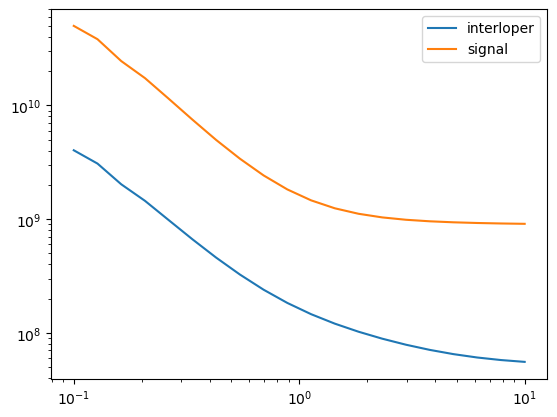

In [44]:
plt.plot(kvals, pkint, label="interloper")
plt.loglog(kvals, pk1, label="signal")

plt.legend(loc=0)

In [45]:
def compute_derivatives_pk3d_interlopers(
                      k_values,
                      z,
                      params_fisher, 
                      line_name='CII158',
                      sfr_model="Silva15",
                      model_name ="Alma_scalling",
                      nu_obs=410, 
                      dnu_obs=40,
                      zlim=10):
    
    
    param_numbers=len(params_fisher)
    dcldp=[]
    
    for i in range(param_numbers):
        p=list(params_fisher.keys())[i]
        print("varying :", p)
        params_deriv = params_fisher.copy()	
        params_deriv[p] = params_deriv[p] + steps[p]
        
        updated_params = {
        key: params_deriv[key] if key in params_deriv else cosmo_params_inputs[key]
        for key in cosmo_params_inputs}
        
        cosmo_setup = cosmos.cosmo(h = updated_params['h'],
                                    omega_lambda = updated_params['omega_lambda'],
                                    omega_b = updated_params['omega_b'],
                                    omega_m = updated_params['omega_m'],
                                    tau = updated_params['tau'],
                                    ns = updated_params['ns'],
                                    sigma_8 = updated_params['sigma_8'],
                                    halo_model = updated_params['halo_model'],
                                    halo_mass_def = updated_params['halo_mass_def'],
                                    M_min = updated_params['M_min'],
                                    M_max = updated_params['M_max'],
                                    delta_c = updated_params['delta_c'],
                                    bias_model = updated_params['bias_model'],
                                    bias_mass_def = updated_params['bias_mass_def'])


        
        pk_plus =  pk3d_interloper(k_values,
                                 model_name=model_name,
                                 line_name=line_name,
                                 sfr_model =sfr_model, 
                                 params_fisher=params_deriv,
                                 nu_obs= nu_obs, 
                                 dnu_obs = dnu_obs,
                                 zlim= zlim)

        
        del params_deriv
        del updated_params
        
        
        
        
        params_deriv = params_fisher.copy()
        params_deriv[p] = params_deriv[p] - steps[p] 
        
        updated_params = {
        key: params_deriv[key] if key in params_deriv else cosmo_params_inputs[key]
        for key in cosmo_params_inputs}
        
        cosmo_setup = cosmos.cosmo(h = updated_params['h'],
                                    omega_lambda = updated_params['omega_lambda'],
                                    omega_b = updated_params['omega_b'],
                                    omega_m = updated_params['omega_m'],
                                    tau = updated_params['tau'],
                                    ns = updated_params['ns'],
                                    sigma_8 = updated_params['sigma_8'],
                                    halo_model = updated_params['halo_model'],
                                    halo_mass_def = updated_params['halo_mass_def'],
                                    M_min = updated_params['M_min'],
                                    M_max = updated_params['M_max'],
                                    delta_c = updated_params['delta_c'],
                                    bias_model = updated_params['bias_model'],
                                    bias_mass_def = updated_params['bias_mass_def'])
        
        
        
        pk_minus = pk3d_interloper(k_values,
                                                 model_name=model_name,
                                                 line_name=line_name,
                                                 sfr_model =sfr_model, 
                                                 params_fisher=params_deriv,
                                                 nu_obs= nu_obs, 
                                                 dnu_obs = dnu_obs,
                                                 zlim= zlim)
        
        
        dcldp_cal=(pk_plus - pk_minus)/ (2. * steps[p])
        dcldp.append(dcldp_cal)
        
        del params_deriv
        
    return dcldp
        

    
    

In [46]:
def fisher_pk3d_interoper(k_values,
                      z,
                      params_fisher,
                      derivative_matrix=None,
                      cov_matrix=None,
                      line_name='CII158',
                      sfr_model="Silva15",
                      model_name ="Alma_scalling",
                      nu_obs=410, 
                      dnu_obs=40,
                      zlim=10):
    
    # This function calculates the fisher matrix for a given covariance matrix. If derivative is precomputed
    # it can can be passed as an input, otherwise, the code will calculate the derivative. 
    
    
    if derivative_matrix is None:
        print("Calculating derivative")
        derivative = compute_derivatives_pk3d_interlopers(
                      k_values,
                      z,
                      params_fisher, 
                      line_name= line_name,
                      sfr_model= sfr_model,
                      model_name = model_name,
                      nu_obs = nu_obs, 
                      dnu_obs = dnu_obs,
                      zlim = zlim)
        
    else:
        derivative = derivative_matrix
        
    
    nparams=len(params_fisher)
    F=np.zeros((nparams, nparams))
    clderiv_i = derivative
    clderiv_j = derivative
    

    for i in range(nparams):
        for j in range(nparams):
            F[i][j]=np.sum(clderiv_i[i]* cov_matrix**-1 * clderiv_j[j]) 
            
    return F

In [47]:
params_fisher = {#"a_off": 7,
                 #"b_off": 0.99,
                 'h': 0.6776,
                 'omega_lambda': 0.6889,
                 'omega_b': 0.0489,
                 'omega_m': 0.3111,
                 'ns': 0.9665,
                 'sigma_8': 0.81}

params_fisher_input, steps = configure_params_fisher(params_fisher)


In [48]:
cosmo_setup = cosmos.cosmo(sigma_8 =0.85)
pk1 = lt.Pk_line(kvals, z, model_name="Alma_scalling", params_fisher=params_fisher_input)
pk_err = 0.1 * pk1

In [58]:
Fij = fisher_pk3d(kvals,
                      z,
                      params_fisher_input,
                      derivative_matrix=None,
                      cov_matrix=cov_mat,
                      line_name='CII158',
                      sfr_model="Silva15",
                      model_name ="Alma_scalling")

Calculating derivative
varying : h
varying : omega_lambda
varying : omega_b
varying : omega_m
varying : ns
varying : sigma_8


In [51]:
Fij_int = fisher_pk3d_interoper(kvals,
                      z,
                      params_fisher_input,
                      derivative_matrix=None,
                      cov_matrix=cov_mat,
                      line_name='CII158',
                      sfr_model="Silva15",
                      model_name ="Alma_scalling")

Calculating derivative
varying : h
Calculating powerspectrum for CII158 lines at z=3.63
Calculating powerspectrum for CO43 lines at z=0.12
Calculating powerspectrum for CO54 lines at z=0.40
Calculating powerspectrum for CO65 lines at z=0.68
Calculating powerspectrum for CO76 lines at z=0.96
Calculating powerspectrum for CO87 lines at z=1.24
Calculating powerspectrum for CO98 lines at z=1.52
Calculating powerspectrum for CO109 lines at z=1.80
Calculating powerspectrum for CO1110 lines at z=2.08
Calculating powerspectrum for CO1211 lines at z=2.36
Calculating powerspectrum for CO1312 lines at z=2.64
Calculating powerspectrum for OIII88 lines at z=7.31
Calculating powerspectrum for CII158 lines at z=3.63
Calculating powerspectrum for CO43 lines at z=0.12
Calculating powerspectrum for CO54 lines at z=0.40
Calculating powerspectrum for CO65 lines at z=0.68
Calculating powerspectrum for CO76 lines at z=0.96
Calculating powerspectrum for CO87 lines at z=1.24
Calculating powerspectrum for CO98

In [59]:
cov_params= np.linalg.inv(Fij)
cov_params_int = np.linalg.inv(Fij_int)

In [60]:
params_fisher_names= list(params_fisher_input.keys())

params_label=params_fisher_names
params_fisher_names_plot=params_fisher_names

mean=[params_fisher[params_fisher_names_plot[i]] for i in range(len(params_fisher_names_plot))]

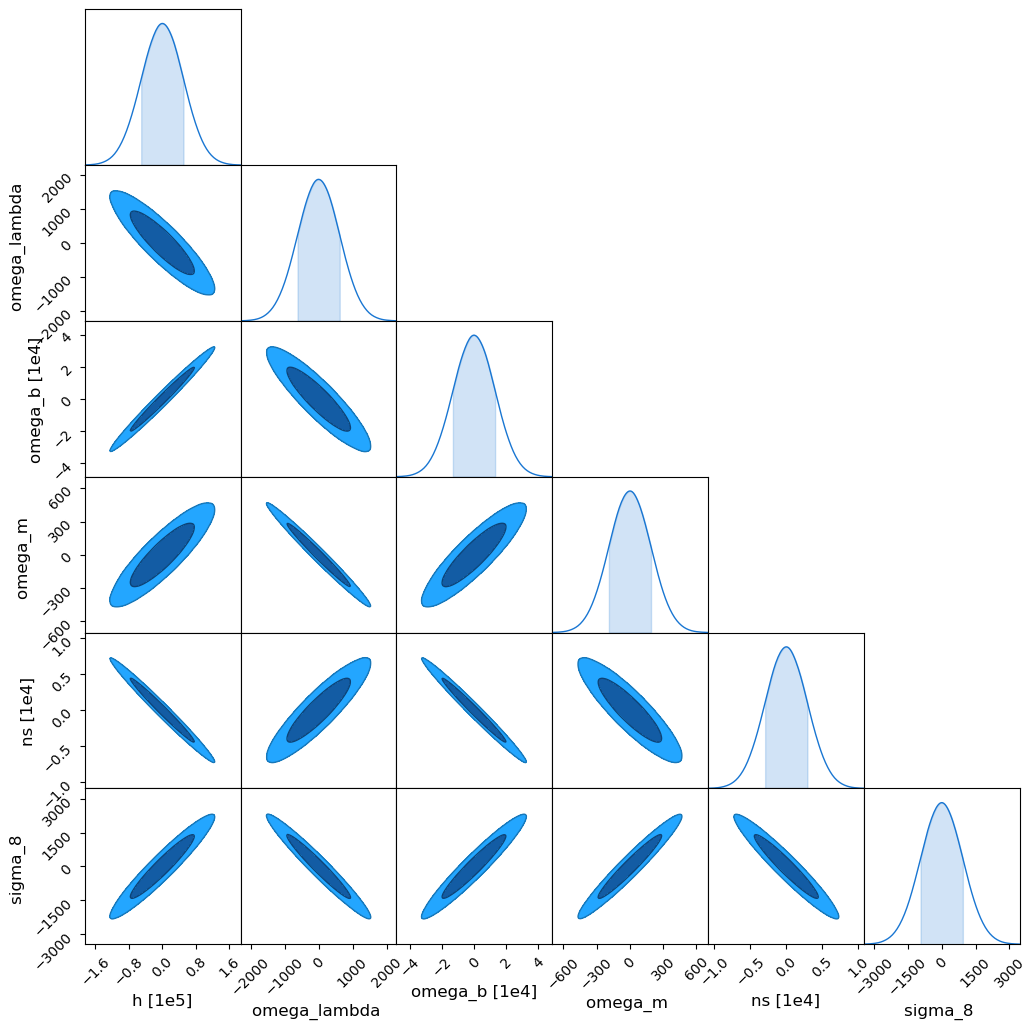

In [61]:
c = ChainConsumer()

#c.add_covariance(mean, cov_params, parameters=params_label)
c.add_covariance(mean, cov_params_int, parameters=params_label)

fig = c.plotter.plot(figsize=(8,8))
fig.set_size_inches(3+ fig.get_size_inches()) 

In [62]:
def get_reduced_fisher(params_fisher, parameters_to_remove, Fij):

    # Find the indices of the parameters to remove
    param_indices_to_remove = [list(params_fisher.keys()).index(param) for param in parameters_to_remove]

    # Remove the rows and columns corresponding to the parameters to remove
    Fij_new = np.delete(Fij, param_indices_to_remove, axis=0)
    Fij_new = np.delete(Fij_new, param_indices_to_remove, axis=1)

    # Get the remaining parameter names
    remaining_parameters = [param for param in params_fisher.keys() if param not in parameters_to_remove]

    # Create a dictionary of remaining parameters with their values
    remaining_parameters_values = {param: params_fisher[param] for param in remaining_parameters}
    
    return Fij_new, remaining_parameters_values




In [63]:
parameters_to_remove = ["omega_lambda", "ns",  "omega_b", "h"]

Fij_int_final, params_final = get_reduced_fisher(params_fisher, parameters_to_remove, Fij_int)

Fij_final, params_final = get_reduced_fisher(params_fisher, parameters_to_remove, Fij)

cov_params= np.linalg.inv(Fij_final)
cov_params_int = np.linalg.inv(Fij_int_final)

params_fisher_names= list(params_final.keys())

params_label = params_fisher_names
params_fisher_names_plot = params_fisher_names

mean=[params_final[params_fisher_names_plot[i]] for i in range(len(params_fisher_names_plot))]

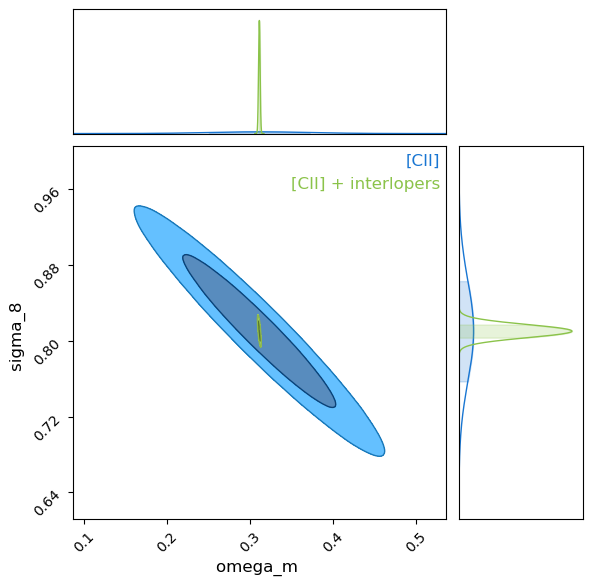

In [64]:
c = ChainConsumer()

c.add_covariance(mean, cov_params, parameters=params_label, name="[CII]")
c.add_covariance(mean, cov_params_int, parameters=params_label, name="[CII] + interlopers")

fig = c.plotter.plot(figsize=(3,3))
fig.set_size_inches(3+ fig.get_size_inches()) 

In [ ]:
params_fisher_names_plot 

In [41]:
int_line_list = [
    "CII158",
    "CO10",
    "CO21",
    "CO32",
    "CO43",
    "CO54",
    "CO65",
    "CO76",
    "CO87",
    "CO98",
    "CO109",
    "CO1110",
    "CO1211",
    "CO1312",
    "OIII88",
]
